In [3]:
h = 1e-5

f = lambda x:x*x

df = lambda x: (f(x+h)-f(x))/h

df(3)

6.000009999951316

In [4]:
3+2

5

In [35]:
from typing import Union
from graphviz import Digraph
class Value:
    def __init__(self,val:Union[int,float],_children=(),label="",_op=""):
        self.val:Union[int,float]=val
        self.grad:float=0
        self._children=_children
        self.label=label
        self._op=_op

    def __repr__(self) -> str:
         return f"{self.label} || Value :  {self.val} | Grad : {self.grad}"
    
    def __add__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        return  Value(self.val+other.val,_children=(self,other),_op="+")
        
    def __sub__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other = Value(other)
        return  Value(self.val-other.val,_children=(self,other),_op="-")
        # return self + -1*other 

    def __mul__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other=Value(other)
        return  Value(self.val*other.val,_children=(self,other),_op="*")


    def __truediv__(self,other:Union[int,float,'Value'])->'Value':
        if isinstance(other,(float,int)):
            other = Value(other)
        return  Value(self.val/other.val,_children=(self,other),_op="/")
        # return Value(self.val*(other.val**-1))
        
    def __radd__(self,other:Union[int,float,'Value'])->'Value':
            return self+other
    
    def __rmul__(self,other:Union[int,float,'Value'])->'Value':
        return self*other

    def __rsub__(self,other:Union[int,float,'Value'])->'Value':
        return self-other
    
    def __pow__(self,other:Union[int,float])->'Value':
        assert isinstance(other,(int,float)),"Error , power fn only supports integers and floats"
        return Value(self.val**other,_children=(self,other),_op="**")
    
    def _get_edges_nodes(self):
        edges=set()
        nodes=set()
        def dfs(node):
            if node not in nodes:
                for child in  node._children:
                    edges.add((child,node))
                    dfs(child)
                nodes.add(node)
        dfs(self)
        return nodes,edges

    def graph(self):
        graph=Digraph(format="svg",graph_attr={'rankdir':'LR'})
        nodes,edges=self._get_edges_nodes()
        for node in nodes:
            node_id=str(id(node))
            graph.node(name=node_id,label=f"{node.label} | value = {node.val} | grad = {node.grad}",shape="box")
            if node._op:
                op_id = node_id + node._op
                graph.node(name=op_id,label=node._op, shape="circle")
                graph.edge(op_id,node_id)

        for node1,node2 in edges:
            n1_id = str(id(node1))
            n2_id = str(id(node2)) + node2._op
            graph.edge(n1_id,n2_id)
        return graph
        

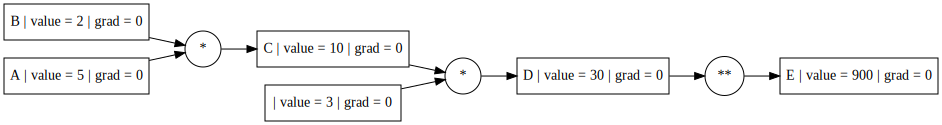

In [36]:
a=Value(5,label='A')
b=Value(2,label='B')
c=a*b;c.label='C';
d=c*Value(3); d.label='D';
e=d**2; e.label='E'
e.graph()

In [10]:
a._op


''

In [11]:
d._op

'*'